# Project Check-In 6

**Responses to Check-In Questions**

2) The metrics we used to evaluate our performance were the R² score and the mean squared error for the training and validation sets. The R² score indicates the proportion of variance that the model explains; at .5921, the model explains the variance in the exam scores reasonably well. Additonally, the MSE helps us see how close our predictions are to the actual values, and calculating it for both the training and validation sets shows that our model is not overfitting, as the MSE for the validation set is not much higher than the training set. The scatter plot between the predicted and actual values was also a helpful tool to visualize the model's performance against the ideal fit line.

3) To train the model, we used a feedforward neural network with an input layer with a size equal to the number of features, a hidden layer with a size of 64, and a single output node. We used the ReLU activation function, and trained the model for 500 epochs with the MSE loss function and the Stochastic Gradient Descent optimizer. 
To select hyperparameters, we initially tested with 100 epochs and a learning rate of 0.01.  However, increasing the epochs to 500 and decreasing the learning rate to 0.001 resulted in the smallest loss and the best R² score. We kept the initial hidden layer size of 64, as changing it did not improve the results. 


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import AgglomerativeClustering

complete_data = pd.read_csv("StudentPerformanceFactors.csv")
print(np.__version__)

1.24.3


In [104]:
# Clean the data by removing rows with empty values
columns_to_drop = ["Extracurricular_Activities", "Peer_Influence", "Physical_Activity", "Gender"]
data = complete_data.drop(columns=columns_to_drop)
data = data.dropna()
data.isna().sum()
# Convert categorical columns to numerical to support clustering using euclidean (as shown in k-means)
# Convert low medium and high to 0, 1, 2
data['Parental_Involvement'] = data['Parental_Involvement'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Access_to_Resources'] = data['Access_to_Resources'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Motivation_Level'] = data['Motivation_Level'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Family_Income'] = data['Family_Income'].map({'Low': 1, 'Medium': 2, 'High': 3})
data['Teacher_Quality'] = data['Teacher_Quality'].map({'Low': 1, 'Medium': 2, 'High': 3})
# Convert "Yes" to 1 and "No" to 0
data['Learning_Disabilities'] = data['Learning_Disabilities'].map({'Yes': 1, 'No': 0})
data['Internet_Access'] = data['Internet_Access'].map({'Yes': 1, 'No': 0})
# Convert Parental Education
data['Parental_Education_Level'] = data['Parental_Education_Level'].map({
    'High School': 1,
    'College': 2,
    'Postgraduate': 3
})
# Convert School Type
data['School_Type'] = data['School_Type'].map({'Private': 1, 'Public': 0})
# Convert Distance From Home
data['Distance_from_Home'] = data['Distance_from_Home'].map({
    'Near': 1,
    'Moderate': 2,
    'Far': 3
})
data.sample(10)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Exam_Score
588,25,86,2,2,7,81,1,1,1,3,1,0,0,1,1,69
6421,15,79,3,2,6,88,2,1,3,3,2,0,0,3,2,69
3457,18,93,2,2,7,76,1,1,2,2,2,1,0,1,1,96
1479,17,67,3,2,10,51,2,1,3,1,2,0,0,1,1,65
4071,16,90,3,2,7,66,2,1,0,3,3,0,0,1,2,67
6409,21,89,2,2,6,97,2,0,1,1,2,1,0,3,3,68
1966,19,91,2,1,8,74,1,1,4,2,2,0,1,3,1,69
5520,16,94,1,2,6,66,2,1,3,2,3,0,0,2,1,69
1704,22,93,2,3,6,69,3,1,0,3,1,0,1,1,1,69
6379,20,63,1,1,9,53,1,1,1,2,2,0,0,1,1,60


In [105]:
## setup features and labels
X = data.drop("Exam_Score", axis=1).values
y = data["Exam_Score"].values

In [106]:
## split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
## scale the features, since not all on the same scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [108]:
## Convert to Tensors so we can use the tensor module' NN functionalities
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

In [109]:
## creating the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_dim, hidden_dim, output_dim)
loss_fn = nn.MSELoss()
## the lr here is learning rate, 0.001 seems to do better than the standard 0.01
optimizer = optim.SGD(model.parameters(), lr=0.001)



### Training the Neural Network ###
Epoch [10/100], Loss: 3482.0103, Validation Loss: 3311.5393
Epoch [20/100], Loss: 1113.4249, Validation Loss: 890.2175
Epoch [30/100], Loss: 49.8318, Validation Loss: 38.2610
Epoch [40/100], Loss: 11.0774, Validation Loss: 11.1188
Epoch [50/100], Loss: 9.6846, Validation Loss: 9.8947
Epoch [60/100], Loss: 9.4254, Validation Loss: 9.6312
Epoch [70/100], Loss: 9.2615, Validation Loss: 9.4640
Epoch [80/100], Loss: 9.1132, Validation Loss: 9.3160
Epoch [90/100], Loss: 8.9729, Validation Loss: 9.1780
Epoch [100/100], Loss: 8.8397, Validation Loss: 9.0480


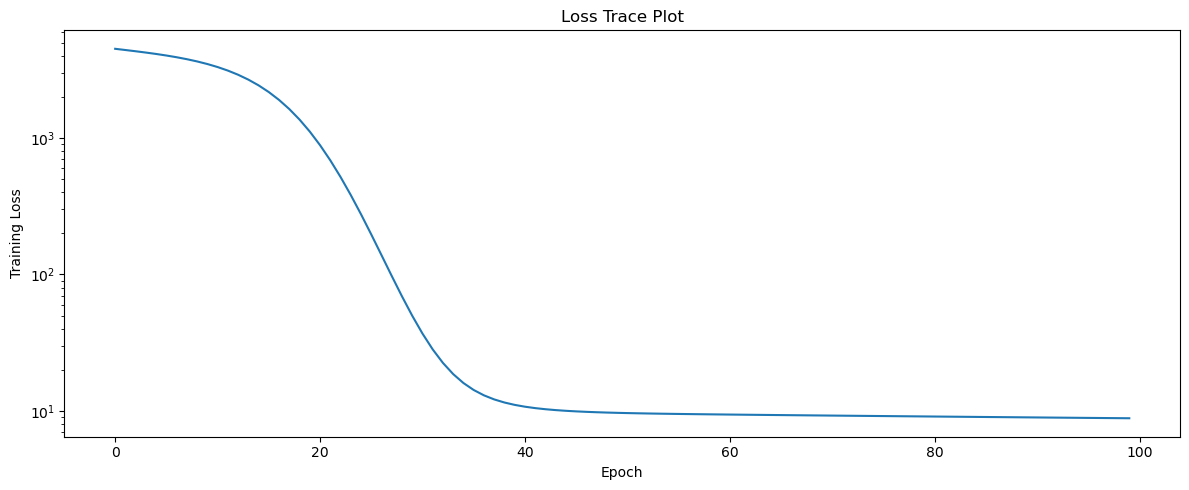


### Detailed Neural Network Explanation ###


In [110]:
# Training loop
print("\n### Training the Neural Network ###")
epochs = 100

# Lists to store values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Forward pass
    predictions = model(X_train_t).squeeze()
    loss = loss_fn(predictions, y_train_t)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate validation loss and accuracies
    with torch.no_grad():
        val_predictions = model(X_test_t).squeeze()
        val_loss = loss_fn(val_predictions, y_test_t)
        
    # Store values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))


# Loss trace plot
plt.plot(train_losses)
plt.title('Loss Trace Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.yscale('log')  # Log scale to better visualize convergence

plt.tight_layout()
plt.show()

# Detailed Neural Network Explanation
print("\n### Detailed Neural Network Explanation ###")


R² Score: 0.4177


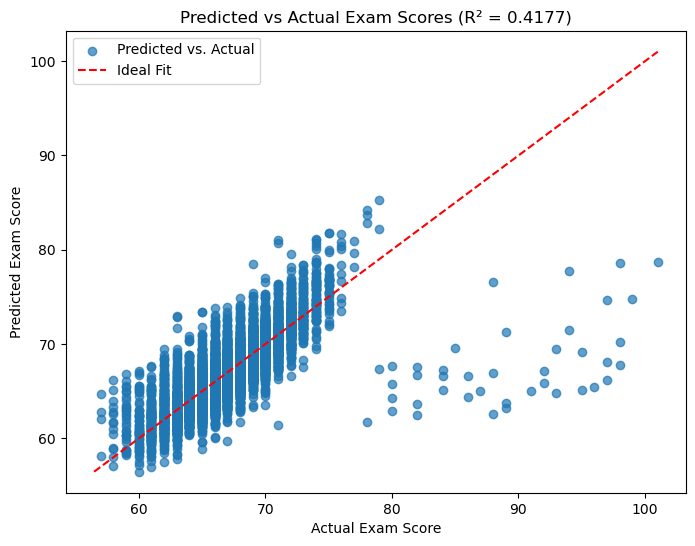

In [111]:
# Switch model to evaluation mode
model.eval()

# Get predictions for both training and test data
with torch.no_grad():
    train_predictions = model(X_train_t).squeeze()
    test_predictions = model(X_test_t).squeeze()
    
# Convert to numpy for plotting and R² calculation
train_predictions_np = train_predictions.detach().numpy()
test_predictions_np = test_predictions.detach().numpy()
train_actuals_np = y_train_t.numpy()
test_actuals_np = y_test_t.numpy()

# Calculate R² score using test data
r2 = r2_score(test_actuals_np, test_predictions_np)
print(f"R² Score: {r2:.4f}")

# Create the scatter plot (using training data)
plt.figure(figsize=(8, 6))
plt.scatter(train_actuals_np, train_predictions_np, label="Predicted vs. Actual", alpha=0.7)

# Plot a diagonal line for reference (ideal predictions)
min_val = min(train_actuals_np.min(), train_predictions_np.min())
max_val = max(train_actuals_np.max(), train_predictions_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

plt.title(f"Predicted vs Actual Exam Scores (R² = {r2:.4f})")
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.legend()
plt.show()